# Libraries

In [1]:
import xarray as xr
from datetime import datetime

import torch

from aurora import AuroraSmall, Batch, Metadata, rollout
import matplotlib.pyplot as plt

from pathlib import Path

import cdsapi
import numpy as np
from sklearn.metrics import root_mean_squared_error
import gcsfs

from torch.utils.data import Dataset
from aurora import Batch, Metadata
import os

/home/koomi_aims_ac_za/koomi/projects/AIMS-PROJECT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [4]:
import torch
print(torch.cuda.is_available())


True


# Clear memory

In [5]:
# torch.cuda.empty_cache()

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

# torch.cuda.memory_allocated()

In [6]:

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [7]:
# torch.backends.cuda.enable_mem_efficient_sdp(False)
# torch.backends.cuda.enable_flash_sdp(False)
# torch.backends.cuda.enable_math_sdp(True)

# Load the model

In [3]:
model = AuroraSmall()

model.load_state_dict(torch.load('../model/aurora.pth'))

<All keys matched successfully>

In [5]:
# # model.half()
# tensor = torch.tensor.half()

# Data

## World

In [4]:
fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')
full_era5 = xr.open_zarr(store=store, consolidated=True, chunks=None)
# df_2022 = ds.sel({'time':np.arange('2022-01-01','2023-01-11',dtype='datetime64[ns]')})

### Subset data from 2022

In [5]:
start_time = '2022-01-01'
end_time = '2022-01-31'
data_inner_steps = 6  # process every 6th hour

sliced_era5_world = (
    full_era5
    # [['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind']]
    # .pipe(
    #     xarray_utils.selective_temporal_shift,
    #     variables=model.forcing_variables,
    #     time_shift='24 hours',
    # )
    .sel(time=slice(start_time, end_time))
    .isel(time=slice(None, -2))
    # .compute()
)

In [6]:
target_sliced_era5_world = (
    full_era5
    .sel(time=slice(start_time, end_time))  # Select the time range
    .isel(time=slice(2, None))  # Skip the first two time steps
)

In [12]:
print("Feature sample (index 2):", sliced_era5_world.isel(time=2).time.values)
print("Target sample (index 0):", target_sliced_era5_world.isel(time=0).time.values)


Feature sample (index 2): 2022-01-01T12:00:00.000000000
Target sample (index 0): 2022-01-01T12:00:00.000000000


In [13]:
len(target_sliced_era5_world.time)

122

In [14]:
len(sliced_era5_world.time)

122

# Draft

In [86]:
sliced_era5_world

<xarray.Dataset> Size: 116GB
Dimensions:                                           (time: 122,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 976B ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 507MB ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 507MB ...
    10m_wind_speed                                    (time, latitude, longitude) float32 507MB ...
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 507MB ...
    2m_temperature                                    (time, latitude, longitude) float32 507MB ...
    above_ground                                      (time, level, latitude, longitude) float32 7GB ...
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 507MB ...
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 507MB ...
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 507MB ...
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 507MB ...
    vorticity                                         (time, level, latitude, longitude) float32 7GB ...
    wind_speed                                        (time, level, latitude, longitude) float32 7GB ...

In [12]:
import xarray as xr
import numpy as np


In [10]:
R = 6371.0  # Earth's radius in kilometers


In [7]:
lat_rad = np.deg2rad(sliced_era5_world.latitude)
lon_rad = np.deg2rad(sliced_era5_world.longitude)


In [8]:
dlat = np.abs(np.diff(lat_rad).mean())  # Average latitude difference
dlon = np.abs(np.diff(lon_rad).mean())  # Average longitude difference


In [11]:
# Calculate the area for each latitude band
areas = R**2 * dlon * np.abs(np.sin(lat_rad + dlat/2) - np.sin(lat_rad - dlat/2))

# Expand areas to match the shape of the grid
area_grid = np.outer(areas, np.ones(len(sliced_era5_world.longitude)))  # Shape: (64, 80)


In [14]:
area_grid[1:,:].shape

(720, 1440)

### Surface variables

In [15]:
# List of surface variable names
surface_vars = ['2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure']

# Select surface variables
surf_vars_ds = sliced_era5_world[surface_vars]
target_surf_vars_ds = target_sliced_era5_world[surface_vars]


### Atmospherique variables

In [16]:
atmostpheric_variables = ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"]
atmos_vars_ds = sliced_era5_world[atmostpheric_variables]
target_atmos_vars_ds = target_sliced_era5_world[atmostpheric_variables]

## Static variables

In [17]:
static_variables = ["land_sea_mask", "soil_type", "geopotential_at_surface"]
static_vars_ds = sliced_era5_world[static_variables]
target_static_vars_ds = target_sliced_era5_world[static_variables]

In [13]:
# surf_vars_ds

In [14]:
# static_vars_ds["geopotential_at_surface"].values.shape

## Create batches

In [18]:

class ERA5ZarrDataset(Dataset):
    def __init__(self, surf_vars_ds, atmos_vars_ds, static_vars_ds, sequence_length):
        self.surf_vars_ds = surf_vars_ds
        self.atmos_vars_ds = atmos_vars_ds
        self.static_vars_ds = static_vars_ds
        self.sequence_length = sequence_length
        self.time_indices = range(sequence_length, len(surf_vars_ds.time))

    def __len__(self):
        return len(self.time_indices)

    def __getitem__(self, idx):
        i = self.time_indices[idx]
        # time_slice = slice(i - self.sequence_length, i)

        surf_vars = {
            "2t": torch.from_numpy(self.surf_vars_ds["2m_temperature"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(self.surf_vars_ds["10m_u_component_of_wind"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(self.surf_vars_ds["10m_v_component_of_wind"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(self.surf_vars_ds["mean_sea_level_pressure"].values[[i - 1, i]][None]),
        }

        static_vars = {
            "z": torch.from_numpy(self.static_vars_ds["geopotential_at_surface"].values),
            "slt": torch.from_numpy(self.static_vars_ds["soil_type"].values),
            "lsm": torch.from_numpy(self.static_vars_ds["land_sea_mask"].values),
        }

        atmos_vars = {
            "t": torch.from_numpy(self.atmos_vars_ds["temperature"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(self.atmos_vars_ds["u_component_of_wind"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(self.atmos_vars_ds["v_component_of_wind"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(self.atmos_vars_ds["specific_humidity"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(self.atmos_vars_ds["geopotential"].values[[i - 1, i]][None]),
        }

        metadata=Metadata(
        lat=torch.from_numpy(self.surf_vars_ds.latitude.values),
        lon=torch.from_numpy(self.surf_vars_ds.longitude.values),
        time=(self.surf_vars_ds.time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in self.atmos_vars_ds.level.values)
    )


        return Batch(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, metadata=metadata)


In [50]:
#   metadata=Metadata(
#         lat=torch.from_numpy(surf_vars_ds.latitude.values),
#         lon=torch.from_numpy(surf_vars_ds.longitude.values),
#         # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
#         # `datetime.datetime`s. Note that this needs to be a tuple of length one:
#         # one value for every batch element.
#         time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
#         atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
#     ),
# )

In [51]:

# class ERA5ZarrDataset(Dataset):
#     def __init__(self, surf_vars_ds, atmos_vars_ds, static_vars_ds, sequence_length):
#         self.surf_vars_ds = surf_vars_ds
#         self.atmos_vars_ds = atmos_vars_ds
#         self.static_vars_ds = static_vars_ds
#         self.sequence_length = sequence_length
#         self.time_indices = range(sequence_length, len(surf_vars_ds.time))

#     def __len__(self):
#         return len(self.time_indices)

#     def __getitem__(self, idx):
#         i = self.time_indices[idx]
#         time_slice = slice(i - self.sequence_length, i)

#         surf_vars = {
#             "2t": torch.from_numpy(self.surf_vars_ds["2m_temperature"].isel(time=time_slice).values[None]),
#             "10u": torch.from_numpy(self.surf_vars_ds["10m_u_component_of_wind"].isel(time=time_slice).values[None]),
#             "10v": torch.from_numpy(self.surf_vars_ds["10m_v_component_of_wind"].isel(time=time_slice).values[None]),
#             "msl": torch.from_numpy(self.surf_vars_ds["mean_sea_level_pressure"].isel(time=time_slice).values[None]),
#         }

#         static_vars = {
#             "z": torch.from_numpy(self.static_vars_ds["geopotential_at_surface"].values),
#             "slt": torch.from_numpy(self.static_vars_ds["soil_type"].values),
#             "lsm": torch.from_numpy(self.static_vars_ds["land_sea_mask"].values),
#         }

#         atmos_vars = {
#             "t": torch.from_numpy(self.atmos_vars_ds["temperature"].isel(time=time_slice).values[None]),
#             "u": torch.from_numpy(self.atmos_vars_ds["u_component_of_wind"].isel(time=time_slice).values[None]),
#             "v": torch.from_numpy(self.atmos_vars_ds["v_component_of_wind"].isel(time=time_slice).values[None]),
#             "q": torch.from_numpy(self.atmos_vars_ds["specific_humidity"].isel(time=time_slice).values[None]),
#             "z": torch.from_numpy(self.atmos_vars_ds["geopotential"].isel(time=time_slice).values[None]),
#         }

#         metadata = Metadata(
#             lat=torch.from_numpy(self.surf_vars_ds.latitude.values),
#             lon=torch.from_numpy(self.surf_vars_ds.longitude.values),
#             time=tuple(self.surf_vars_ds.time.isel(time=time_slice).values.astype("datetime64[s]").tolist(),),
#             atmos_levels=tuple(int(level) for level in self.atmos_vars_ds.level.values),
#         )

#         return Batch(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, metadata=metadata)


In [19]:
world_batches = ERA5ZarrDataset(surf_vars_ds, atmos_vars_ds, static_vars_ds,1)
target_world_batches = ERA5ZarrDataset(target_surf_vars_ds, target_atmos_vars_ds, target_static_vars_ds,1)

In [142]:
i=0
for batch in world_batches:
    feature_data=batch
    i+=1
    if i==3:
        break

In [143]:
i=0
for batch in target_world_batches:
    target_data=batch
    i+=1
    if i==1:
        break

In [145]:
feature_data.surf_vars["2t"].squeeze()[0,:,:]==target_data.surf_vars["2t"].squeeze()[0,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [96]:
for batch in target_world_batches:
    target_data=batch
    break

In [97]:

for batch in world_batches:
    feature_data=batch
    break

In [98]:
i=0
for batch in world_batches:
    feature_data1=batch
    i+=1
    if i==3:
        break

In [99]:
i=0
for batch in world_batches:
    feature_data2=batch
    i+=1
    if i==4:
        break

In [106]:
feature_data1.surf_vars["2t"].squeeze()[1,:,:]==target_data.surf_vars["2t"].squeeze()[1,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [76]:
i=0
for batch in target_world_batches:
    target_data1=batch
    i+=1
    if i==20:
        break

In [77]:
i=0
for batch in target_world_batches:
    target_data2=batch
    i+=1
    if i==21:
        break

In [79]:
target_data1.surf_vars["2t"].squeeze()[1,:,:]==target_data2.surf_vars["2t"].squeeze()[0,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [101]:
feature_data.surf_vars["2t"].squeeze()[1,:,:]==feature_data1.surf_vars["2t"].squeeze()[1,:,:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [49]:
feature_data1.metadata.time

(datetime.datetime(2022, 1, 1, 12, 0),)

In [50]:
target_data.metadata.time

(datetime.datetime(2022, 1, 1, 12, 0),)

In [50]:
feature_data.surf_vars["2t"].squeeze()[0,:,:]==feature_data.surf_vars["2t"].squeeze()[0,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [46]:
feature_data.surf_vars["2t"].squeeze()[1,:,:]==feature_data.surf_vars["2t"].squeeze()[1,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [45]:
feature_data1.surf_vars["2t"].squeeze()[0,:,:]

tensor([[248.1045, 248.1045, 248.1045,  ..., 248.1045, 248.1045, 248.1045],
        [248.5956, 248.5909, 248.5893,  ..., 248.6035, 248.5988, 248.5972],
        [248.9970, 248.9939, 248.9891,  ..., 249.0112, 249.0049, 249.0017],
        ...,
        [248.6601, 248.6554, 248.6491,  ..., 248.6727, 248.6696, 248.6633],
        [248.7955, 248.7939, 248.7908,  ..., 248.8034, 248.8018, 248.7987],
        [248.9970, 248.9970, 248.9970,  ..., 248.9970, 248.9970, 248.9970]])

In [46]:
target_data.surf_vars["2t"].squeeze()[0,:,:]

tensor([[241.6527, 241.6527, 241.6527,  ..., 241.6527, 241.6527, 241.6527],
        [241.8501, 241.8456, 241.8442,  ..., 241.8620, 241.8575, 241.8546],
        [242.2345, 242.2286, 242.2227,  ..., 242.2523, 242.2464, 242.2405],
        ...,
        [241.5592, 241.5592, 241.5592,  ..., 241.5607, 241.5607, 241.5607],
        [241.8234, 241.8234, 241.8234,  ..., 241.8204, 241.8234, 241.8234],
        [242.0935, 242.0935, 242.0935,  ..., 242.0935, 242.0935, 242.0935]])

In [83]:
feature_data1.surf_vars["2t"].squeeze()[1,:,:]==target_data.surf_vars["2t"].squeeze()[1,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [103]:
target_data.surf_vars["2t"].squeeze()[0,:,:]==target_data.surf_vars["2t"].squeeze()[0,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [100]:
data.metadata.time

(datetime.datetime(2022, 1, 1, 6, 0),)

In [93]:
feature_data.surf_vars.metadata.time

AttributeError: 'dict' object has no attribute 'metadata'

In [103]:
feature_data.surf_vars["2t"].squeeze()[1,:,:]

tensor([[248.4398, 248.4398, 248.4398,  ..., 248.4398, 248.4398, 248.4398],
        [249.0049, 249.0017, 248.9986,  ..., 249.0096, 249.0080, 249.0064],
        [249.5086, 249.5039, 249.5007,  ..., 249.5164, 249.5117, 249.5101],
        ...,
        [250.4027, 250.3964, 250.3916,  ..., 250.4247, 250.4168, 250.4090],
        [250.6482, 250.6451, 250.6404,  ..., 250.6592, 250.6545, 250.6514],
        [250.7490, 250.7490, 250.7490,  ..., 250.7490, 250.7490, 250.7490]])

In [53]:
for batch, target_batch in zip(world_batches, target_world_batches):
    print(batch.metadata.time, target_batch.metadata.time)

(datetime.datetime(2022, 1, 1, 0, 0),) (datetime.datetime(2022, 1, 1, 6, 0),)
(datetime.datetime(2022, 1, 1, 6, 0),) (datetime.datetime(2022, 1, 1, 12, 0),)
(datetime.datetime(2022, 1, 1, 12, 0),) (datetime.datetime(2022, 1, 1, 18, 0),)


(datetime.datetime(2022, 1, 1, 18, 0),) (datetime.datetime(2022, 1, 2, 0, 0),)
(datetime.datetime(2022, 1, 2, 0, 0),) (datetime.datetime(2022, 1, 2, 6, 0),)
(datetime.datetime(2022, 1, 2, 6, 0),) (datetime.datetime(2022, 1, 2, 12, 0),)
(datetime.datetime(2022, 1, 2, 12, 0),) (datetime.datetime(2022, 1, 2, 18, 0),)
(datetime.datetime(2022, 1, 2, 18, 0),) (datetime.datetime(2022, 1, 3, 0, 0),)
(datetime.datetime(2022, 1, 3, 0, 0),) (datetime.datetime(2022, 1, 3, 6, 0),)


KeyboardInterrupt: 

In [20]:
# world_batches

In [27]:
data = iter(world_batches)


In [28]:
data0 = next(data)

KeyboardInterrupt: 

In [38]:
data0.metadata.time

(datetime.datetime(2022, 1, 1, 12, 0),)

In [40]:
data0.surf_vars["2t"].shape

torch.Size([1, 2, 721, 1440])

In [ ]:
data0.surf_vars_ds["t2m"][2 + 1].values

In [47]:
import itertools

In [48]:
iter1, iter2 = itertools.tee(iter(world_batches))

### South Africa Data

In [29]:
# sa_area = [
#     -22.12,  # North latitude
#     15.125,   # West longitude
#     -37.875,  # South latitude
#     34.875    # East longitude
# ]

# lat_min, lon_min, lat_max, lon_max = sa_area

In [23]:
start_time = '2022-01-01'
end_time = '2023-01-31'
data_inner_steps = 6  # process every 6th hour

# Adjusted latitude and longitude to get exactly 64 x 80 grid points
lat_max = -22.00  # Keep latitude unchanged (64 rows are correct)
lat_min = -37.75  # Keep latitude unchanged

lon_min = 15.25   # Keep longitude start the same
lon_max = 35.00   # Increase longitude slightly to add 1 extra column

sliced_era5_SA = (
    full_era5
    .sel(
        time=slice(start_time, end_time, data_inner_steps),
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)  # Expanding max longitude
    )
)


In [31]:
surf_vars_ds_SA = sliced_era5_SA[surface_vars]
atmos_vars_ds_SA = sliced_era5_SA[atmostpheric_variables]
static_vars_ds_SA = sliced_era5_SA[static_variables]

In [32]:
SA_batches = ERA5ZarrDataset(surf_vars_ds_SA, atmos_vars_ds_SA, static_vars_ds_SA,1)

## Predictions Function

In [20]:
def predict_fn(model, batch):
    model.eval()
    model = model.to("cuda")
    with torch.inference_mode():
        preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]
    model = model.to("cpu")
    return preds

# RMSEs World dataset

In [21]:
def rmse_fn(model, feature_batch, target_bacth, var_name, var_type="surface", atmos_level_idx=0):
    predictions = predict_fn(model, batch=feature_batch)
    two_steps_rmse = []
    pred_dates = []
    for i in range(len(predictions)):
        pred = predictions[i]
        if var_type=="surface":
            prediction = pred.surf_vars[var_name][0, 0].numpy()
            actual = target_batch.surf_vars[var_name].squeeze()[i,:,:][:-1, :]
            # actual = target_batch.surf_vars[var_name][0, 0].numpy()
            
            rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            two_steps_rmse.append(rmse)
            pred_dates.append(pred.metadata.time[0])
        # Atmospherique variable
        elif var_type=="atmosphere":
            prediction = pred.atmos_vars[var_name].squeeze()[atmos_level_idx,:,:].numpy().squeeze()
            actual = target_batch.atmos_vars[var_name].squeeze()[i,:,:][:-1, :]
            # actual = target_batch.atmos_vars[var_name].squeeze()[i,atmos_level_idx,:,:].numpy()[:-1,:]
            rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            two_steps_rmse.append(rmse)
            pred_dates.append(pred.metadata.time[0])
    return two_steps_rmse, pred_dates

# RMSEs South Africa dataset

In [148]:
def rmse(actual, prediction):
    return ((actual-prediction)**2).mean()

In [22]:
def rmse_fn_sa(model, actual_batch, var_name, var_type="surface",  atmos_level_idx=0):
    predictions = predict_fn(model, batch=actual_batch)
    two_steps_rmse = []
    pred_dates = []
    for i in range(len(predictions)):
        pred = predictions[i]
        if var_type=="surface":
            # prediction = pred.surf_vars[var_name][0, 0].numpy()
            # actual = actual_batch.surf_vars[var_name][0, 0].numpy()
            # rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            prediction = pred.surf_vars[var_name][0, 0].numpy()
            actual = target_batch.surf_vars[var_name].squeeze()[i,:,:][:-1, :]
            # rmse1 = rmse(actual, prediction)
            two_steps_rmse.append(rmse)
            pred_dates.append(pred.metadata.time[0])
            # print(rmse, rmse1)
        elif var_type=="atmosphere":
            prediction = pred.atmos_vars[var_name].squeeze()[atmos_level_idx,:,:].numpy().squeeze()
            actual = actual_batch.atmos_vars[var_name].squeeze()[i,atmos_level_idx,:,:].numpy()
            rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            two_steps_rmse.append(rmse)
            pred_dates.append(pred.metadata.time[0])
    return two_steps_rmse, pred_dates

# PLot RMSES

In [23]:

def plot_rmses(variable, rmses_world, rmses_sa, 
               figsize=(12, 8), fontsize=18,
               alpha=0.2, date_ranges=None, 
               title="Two steps forward prediction: RMSEs",
               save_path="../report/rmses_world_SA"):

    fig, ax = plt.subplots(figsize=figsize, dpi=1000)

    # Extract dates
    date_times_6_hours = [date1 for date1, date2 in date_ranges]
    date_times_12_hours = [date2 for date1, date2 in date_ranges]
    formatted_dates_6_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_6_hours]
    formatted_dates_12_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_12_hours]

    # Convert x-axis to indices
    x_indices = np.arange(len(formatted_dates_6_hours))

    # Select a subset of dates for x-axis labels
    num_ticks = min(6, len(formatted_dates_6_hours))  # Show max 6 ticks
    tick_positions = np.linspace(0, len(formatted_dates_6_hours) - 1, num_ticks, dtype=int)

    ax.plot(x_indices, np.array(rmses_world)[:,0], label="World 6 hours forward prediction")
    ax.plot(x_indices, np.array(rmses_sa)[:,0], label="South Africa 6 hours forward prediction")
    ax.plot(x_indices, np.array(rmses_world)[:,1], label="World 12 hours forward prediction")
    ax.plot(x_indices, np.array(rmses_sa)[:,1], label="South Africa 12 hours forward prediction")

    # Set selected x-ticks
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([formatted_dates_6_hours[i] for i in tick_positions], rotation=30, ha='right')

    ax.legend(
    title="RMSEs\n", title_fontsize=fontsize, markerscale=1.5,
    bbox_to_anchor=(0.98, 0.98), loc="upper left", frameon=False
)

    ax.set_xlabel("Dates")
    ax.set_ylabel("RMSEs")
    ax.set_title(title, fontsize=fontsize, pad=20)
    
    plt.savefig(f"{save_path}/rmse-{variable}.pdf")
    plt.savefig(f"{save_path}/rmse-{variable}.png")
    plt.savefig(f"{save_path}/rmse-{variable}.svg")

    plt.show()


In [24]:

def plot_rmses(variable, rmses_world, rmses_sa, 
               figsize=(12, 8), fontsize=18,
               date_ranges=None, 
               title="Two Steps Forward Prediction: RMSEs",
               save_path="../report/rmses_world_SA",
               atmos_level=None):

    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # Extract dates
    date_times_6_hours = [date1 for date1, date2 in date_ranges]
    date_times_12_hours = [date2 for date1, date2 in date_ranges]
    formatted_dates_6_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_6_hours]
    formatted_dates_12_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_12_hours]

    # Convert x-axis to indices
    x_indices = np.arange(len(formatted_dates_6_hours))

    # Select a subset of dates for x-axis labels
    num_ticks = min(6, len(formatted_dates_6_hours))
    tick_positions = np.linspace(0, len(formatted_dates_6_hours) - 1, num_ticks, dtype=int)

    # Plot RMSEs with improved colors and styles
    ax.plot(x_indices, np.array(rmses_world)[:, 0], label="Global RMSE (6h Forecast)", color="blue", linestyle="-", linewidth=2)
    ax.plot(x_indices, np.array(rmses_sa)[:, 0], label="South Africa RMSE (6h Forecast)", color="orange", linestyle="-", linewidth=2)
    ax.plot(x_indices, np.array(rmses_world)[:, 1], label="Global RMSE (12h Forecast)", color="blue", linestyle="--", linewidth=2)
    ax.plot(x_indices, np.array(rmses_sa)[:, 1], label="South Africa RMSE (12h Forecast)", color="orange", linestyle="--", linewidth=2)

    # Set selected x-ticks
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([formatted_dates_12_hours[i] for i in tick_positions], rotation=30, ha='right')

    # Improve legend appearance
    ax.legend(title="Forecast Horizon", title_fontsize=fontsize-2, fontsize=fontsize-4,
              bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

    # Improve axis labels and title
    ax.set_xlabel("Forecast Date", fontsize=fontsize-2)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=fontsize-2)
    ax.set_title(title, fontsize=fontsize, pad=20)
    if atmos_level:
        # Save the plots
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.pdf", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.png", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.svg", bbox_inches="tight")
    else:
        plt.savefig(f"{save_path}/rmse-{variable}.pdf", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}.png", bbox_inches="tight", dpi=300)
        plt.savefig(f"{save_path}/rmse-{variable}.svg", bbox_inches="tight")

    plt.show()


In [25]:
# data = iter(world_batches)

In [26]:
# data0 = next(data)

In [27]:
# data0.atmos_vars["t"].squeeze()[0,0,:,:].numpy()[:-1,:].shape

In [28]:
# data0.static_vars["lsm"].shape

In [29]:
# data0.surf_vars["10v"].shape

In [157]:
# data0.surf_vars["2t"].shape

In [158]:
# preds = predict_fn(model, data0)

In [159]:
# preds[0].surf_vars["2t"].shape

In [160]:
# preds.surf_vars["10v"][1,:,:,:].shape

In [161]:
# data0.metadata.time

# Surface Variables

## Two-meter temperature in K: 2t

In [162]:
# data0.surf_vars["2t"][1].shape

In [30]:
rmses_world_2t = []
dates_world_2t = []

for batch, target_batch in zip(world_batches, target_world_batches):
    # print(batch.metadata.time)
    rmse, date = rmse_fn(model, feature_batch=batch, target_bacth=target_batch, var_name="2t", var_type="surface")
    rmses_world_2t.append(rmse)
    dates_world_2t.append(date)

In [33]:
# plt.plot(np.array(rmses)[:,0], label="1")
# plt.plot(np.array(rmses)[:,1], label="2")
# plt.legend()

In [34]:
# rmse_fn(model, data0, "2t")

In [35]:
# i=0
# for batch in world_batches:
#    i+=1
# i 

In [23]:
# data = iter(sa_batches)
# data0 = next(data)

In [24]:
# data0.surf_vars["2t"].shape

In [43]:
rmses_SA_2t = []
dates_SA_2t = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "2t", var_type="surface")
    rmses_SA_2t.append(rmse)
    dates_SA_2t.append(date)

In [31]:
np.array(rmses_world_2t)

array([[0.64297462, 0.81056142],
       [0.66571653, 0.80725676],
       [0.64747256, 0.79085732],
       [0.64344192, 0.78815627],
       [0.65558773, 0.83771569],
       [0.67267013, 0.79690671],
       [0.63998479, 0.7775206 ],
       [0.65142643, 0.82794797],
       [0.67610705, 0.80139863],
       [0.64878321, 0.78391188],
       [0.62195015, 0.75908512],
       [0.64276409, 0.82027578],
       [0.6703518 , 0.80241579],
       [0.67262   , 0.78906655],
       [0.62326431, 0.76710409],
       [0.65398151, 0.77169764],
       [0.62939465, 0.80573869],
       [0.65925723, 0.78838933],
       [0.64091665, 0.7714445 ],
       [0.66544425, 0.79534853],
       [0.66985869, 0.8253144 ],
       [0.70008236, 0.81205505],
       [0.65146852, 0.7685585 ],
       [0.65976322, 0.78265059],
       [0.65903258, 0.82132655],
       [0.67279375, 0.80972224],
       [0.64705622, 0.76791722],
       [0.64205861, 0.80830336],
       [0.66468394, 0.83023036],
       [0.68653309, 0.80753607],
       [0.

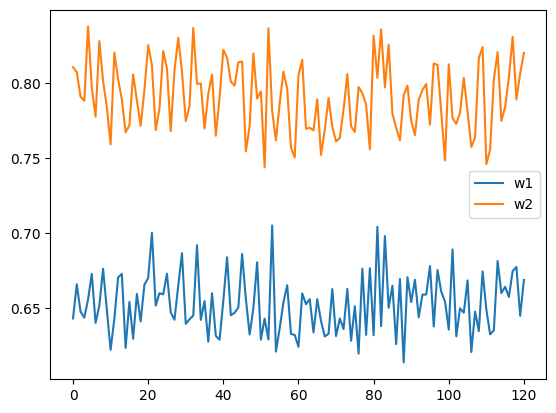

In [32]:
plt.plot(np.array(rmses_world_2t)[:,0], label="w1")
plt.plot(np.array(rmses_world_2t)[:,1], label="w2")
# plt.plot(np.array(rmses_sa)[:,0], label="sa1")
# plt.plot(np.array(rmses_sa)[:,1], label="sa2")
plt.legend()

In [ ]:
# print(sliced_era5.latitude.shape, sliced_era5.longitude.shape)


In [ ]:
plot_rmses("2t",rmses_world_2t, rmses_SA_2t, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_2t, title="Temperature two steps forward prediction: RMSES")

## Ten-meter eastward wind speed in m/s :U10

In [48]:
rmses_world_u10 = []
dates_world_u10 = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "10u", var_type="surface")
    rmses_world_u10.append(rmse)
    dates_world_u10.append(date)

In [49]:
rmses_SA_u10 = []
dates_SA_u10 = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "10u", var_type="surface")
    rmses_SA_u10.append(rmse)
    dates_SA_u10.append(date)

In [ ]:
plot_rmses("u10",rmses_world_u10, rmses_SA_u10, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u10, title="Ten-meter eastward wind speed two steps forward prediction: RMSES")

## Ten-meter southward wind speed in m/s: V10

In [51]:
rmses_world_v10 = []
dates_world_v10 = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "10v", var_type="surface")
    rmses_world_v10.append(rmse)
    dates_world_v10.append(date)

In [52]:
rmses_SA_v10 = []
dates_SA_v10 = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "10v", var_type="surface")
    rmses_SA_v10.append(rmse)
    dates_SA_v10.append(date)

In [ ]:
plot_rmses("v10",rmses_world_v10, rmses_SA_v10, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v10, title="Ten-meter southward wind speed two steps forward prediction: RMSES")

## Mean sea-level pressure in Pa :msl

In [54]:
rmses_world_msl = []
dates_world_msl = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "msl", var_type="surface")
    rmses_world_msl.append(rmse)
    dates_world_msl.append(date)

In [55]:
rmses_SA_msl = []
dates_SA_msl = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "msl", var_type="surface")
    rmses_SA_msl.append(rmse)
    dates_SA_msl.append(date)

In [ ]:
plot_rmses("msl",rmses_world_msl, rmses_SA_msl, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_msl, title="Mean sea-level pressure two steps forward prediction: RMSES")

# Atmosphere

## Temperature in K : t

### 50 hPa

In [57]:
rmses_world_t = []
dates_world_t = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "t", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_t.append(rmse)
    dates_world_t.append(date)

In [58]:
rmses_SA_t = []
dates_SA_t = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "t", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_t.append(rmse)
    dates_SA_t.append(date)

In [ ]:
plot_rmses("t",rmses_world_t, rmses_SA_t, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_t, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [70]:
rmses_world_t_400hpa = []
dates_world_t_400hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "t", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_t_400hpa.append(rmse)
    dates_world_t_400hpa.append(date)

In [71]:
rmses_SA_t_400hpa = []
dates_SA_t_400hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "t", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_t_400hpa.append(rmse)
    dates_SA_t_400hpa.append(date)

In [ ]:
plot_rmses("t",rmses_world_t_400hpa, rmses_SA_t_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_t_400hpa, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [73]:
rmses_world_t_1000hpa = []
dates_world_t_1000hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "t", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_t_1000hpa.append(rmse)
    dates_world_t_1000hpa.append(date)

In [74]:
rmses_SA_t_1000hpa = []
dates_SA_t_1000hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "t", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_t_1000hpa.append(rmse)
    dates_SA_t_1000hpa.append(date)

In [ ]:
plot_rmses("t",rmses_world_t_1000hpa, rmses_SA_t_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_t_1000hpa, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

## Eastward wind speed in m/s u

### 50 hPa

In [76]:
rmses_world_u = []
dates_world_u = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "u", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_u.append(rmse)
    dates_world_u.append(date)

In [77]:
rmses_SA_u = []
dates_SA_u = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "u", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_u.append(rmse)
    dates_SA_u.append(date)

In [ ]:
plot_rmses("u",rmses_world_u, rmses_SA_u, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u, title="Eastward wind speed two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [79]:
rmses_world_u_400hpa = []
dates_world_u_400hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "u", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_u_400hpa.append(rmse)
    dates_world_u_400hpa.append(date)

In [80]:
rmses_SA_u_400hpa = []
dates_SA_u_400hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "u", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_u_400hpa.append(rmse)
    dates_SA_u_400hpa.append(date)

In [ ]:
plot_rmses("u",rmses_world_u_400hpa, rmses_SA_u_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u_400hpa, title="Eastward wind speed  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [82]:
rmses_world_u_1000hpa = []
dates_world_u_1000hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "u", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_u_1000hpa.append(rmse)
    dates_world_u_1000hpa.append(date)

In [83]:
rmses_SA_u_1000hpa = []
dates_SA_u_1000hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "u", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_u_1000hpa.append(rmse)
    dates_SA_u_1000hpa.append(date)

In [ ]:
plot_rmses("u",rmses_world_u_1000hpa, rmses_SA_u_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_u_1000hpa, title="Eastward wind speed  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Southward wind speed in m/s :v

### 50 hPa

In [85]:
rmses_world_v = []
dates_world_v = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "v", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_v.append(rmse)
    dates_world_v.append(date)

In [86]:
rmses_SA_v = []
dates_SA_v = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "v", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_v.append(rmse)
    dates_SA_v.append(date)

In [ ]:
plot_rmses("v",rmses_world_v, rmses_SA_v, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v, title="Southward wind speed two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [88]:
rmses_world_v_400hpa = []
dates_world_v_400hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "v", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_v_400hpa.append(rmse)
    dates_world_v_400hpa.append(date)

In [89]:
rmses_SA_v_400hpa = []
dates_SA_v_400hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "v", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_v_400hpa.append(rmse)
    dates_SA_v_400hpa.append(date)

In [ ]:
plot_rmses("v",rmses_world_v_400hpa, rmses_SA_v_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v_400hpa, title="Southward wind speed  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [91]:
rmses_world_v_1000hpa = []
dates_world_v_1000hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "v", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_v_1000hpa.append(rmse)
    dates_world_v_1000hpa.append(date)

In [92]:
rmses_SA_v_1000hpa = []
dates_SA_v_1000hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "v", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_v_1000hpa.append(rmse)
    dates_SA_v_1000hpa.append(date)

In [ ]:
plot_rmses("v",rmses_world_v_1000hpa, rmses_SA_v_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_v_1000hpa, title="Southward wind speed  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Specific humidity in kg / kg: q

### 50 hPa

In [94]:
rmses_world_q = []
dates_world_q = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "q", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_q.append(rmse)
    dates_world_q.append(date)

In [95]:
rmses_SA_q = []
dates_SA_q = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "q", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_q.append(rmse)
    dates_SA_q.append(date)

In [ ]:
plot_rmses("q",rmses_world_q, rmses_SA_q, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_q, title="Specific humidity two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [97]:
rmses_world_q_400hpa = []
dates_world_q_400hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "q", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_q_400hpa.append(rmse)
    dates_world_q_400hpa.append(date)

In [98]:
rmses_SA_q_400hpa = []
dates_SA_q_400hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "q", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_q_400hpa.append(rmse)
    dates_SA_q_400hpa.append(date)

In [ ]:
plot_rmses("q",rmses_world_q_400hpa, rmses_SA_q_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_q_400hpa, title="Southward wind speed  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [100]:
rmses_world_q_1000hpa = []
dates_world_q_1000hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "q", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_q_1000hpa.append(rmse)
    dates_world_q_1000hpa.append(date)

In [101]:
rmses_SA_q_1000hpa = []
dates_SA_q_1000hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "q", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_q_1000hpa.append(rmse)
    dates_SA_q_1000hpa.append(date)

In [ ]:
plot_rmses("q",rmses_world_q_1000hpa, rmses_SA_q_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_q_1000hpa, title="Specific humidity  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Geopotential in m^2 / s^2 : z

### 50 hPa

In [103]:
rmses_world_z = []
dates_world_z = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "z", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_z.append(rmse)
    dates_world_z.append(date)

In [104]:
rmses_SA_z = []
dates_SA_z = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "z", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_z.append(rmse)
    dates_SA_z.append(date)

In [ ]:
plot_rmses("z",rmses_world_z, rmses_SA_z, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_z, title="Geopotential two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [106]:
rmses_world_z_400hpa = []
dates_world_z_400hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "z", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_z_400hpa.append(rmse)
    dates_world_z_400hpa.append(date)

In [107]:
rmses_SA_z_400hpa = []
dates_SA_z_400hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "z", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_z_400hpa.append(rmse)
    dates_SA_z_400hpa.append(date)

In [ ]:
plot_rmses("z",rmses_world_z_400hpa, rmses_SA_z_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_z_400hpa, title="Geopotential two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [109]:
rmses_world_z_1000hpa = []
dates_world_z_1000hpa = []
for batch in world_batches:
    rmse, date = rmse_fn(model, batch, "z", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_z_1000hpa.append(rmse)
    dates_world_z_1000hpa.append(date)

In [110]:
rmses_SA_z_1000hpa = []
dates_SA_z_1000hpa = []
for batch in SA_batches:
    rmse, date = rmse_fn_sa(model, batch, "z", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_z_1000hpa.append(rmse)
    dates_SA_z_1000hpa.append(date)

In [ ]:
plot_rmses("z",rmses_world_z_1000hpa, rmses_SA_z_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_z_1000hpa, title="Geopotential  two steps forward prediction: RMSES",
            atmos_level="1000hPa")